In [147]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit


In [154]:
# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")

if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    # Strip unnecessary quotes around the value
                    os.environ[key] = value.strip().strip("'").strip('"')

# Initialize database connection
db_util = DatabaseUtility()

# Execute query
db_util.cursor.execute("""
    SELECT * FROM wr_model_data
    WHERE draft_year != 2025 AND draft_year != 2024;
""")

# Fetch all rows
rows = db_util.cursor.fetchall()
# Get column names from cursor description
columns = [desc[0] for desc in db_util.cursor.description]
# Create a DataFrame
df_train = pd.DataFrame(rows, columns=columns)

# Fetch 2025 WR prospects (no avg_fppg_nfl)
db_util.cursor.execute("""
    SELECT * FROM wr_model_data
    WHERE draft_year = 2024;
""")
rows_2025 = db_util.cursor.fetchall()
df_test = pd.DataFrame(rows_2025, columns=columns)

# Close the database connection
db_util.conn.close()

print(list(name for name in df_test['name']))


['Tyrone Tracy Jr.', 'Jacob Cowing', "Jha'Quan Jackson", 'Ainias Smith', 'Xavier Legette', 'Malik Washington', 'Luke McCaffrey', 'Cornelius Johnson', 'Tahj Washington', 'Casey Washington', 'Jamari Thrash', 'Ricky Pearsall', 'Malachi Corley', 'Jalen McMillan', 'Rome Odunze', 'Devaughn Vele', "Ja'lynn Polk", 'Roman Wilson', 'Jermaine Burton', 'Brenden Rice', 'Johnny Wilson', 'Javon Baker', 'Tejhaun Palmer', 'Xavier Worthy', 'Anthony Gould', 'Troy Franklin', 'Marvin Harrison Jr.', 'Keon Coleman', 'Malik Nabers', 'Brian Thomas Jr.', 'Bub Means', 'Devontez Walker', 'Adonai Mitchell', 'Ladd McConkey']


In [155]:
null_columns = df_train.columns[df_train.isnull().any()]
print("Columns with at least one null value:")

print("\nSummary of columns with nulls:")
for col in null_columns:
    null_count = df_train[col].isnull().sum()
    avg_value = df_train[col].mean()
    print(f"{col}: {null_count} missing | Avg (ignoring nulls): {avg_value:.2f}")


Columns with at least one null value:

Summary of columns with nulls:
ras: 37 missing | Avg (ignoring nulls): 7.16
avg_pff_rec_grade: 35 missing | Avg (ignoring nulls): 73.19
peak_pff_rec_grade: 35 missing | Avg (ignoring nulls): 80.41
avg_pff_run_grade: 104 missing | Avg (ignoring nulls): 58.44
peak_pff_run_grade: 104 missing | Avg (ignoring nulls): 63.30
avg_tprr: 35 missing | Avg (ignoring nulls): 0.24
peak_tprr: 35 missing | Avg (ignoring nulls): 0.28
avg_yprr: 36 missing | Avg (ignoring nulls): 2.22
peak_yprr: 36 missing | Avg (ignoring nulls): 2.81
avg_yac_per_rec: 35 missing | Avg (ignoring nulls): 5.90
peak_yac_per_rec: 35 missing | Avg (ignoring nulls): 7.56
peak_season_age_college: 1 missing | Avg (ignoring nulls): 20.07


In [156]:
# Fill draft_cap missing values with 300
df_train['draft_cap'].fillna(300, inplace=True)
df_test['draft_cap'].fillna(300, inplace=True)

# Save identifiers of test set for later before dropping
df_test_identifiers = df_test[["player_id", "name"]].copy()

# Drop unneeded columns
drop_cols = ['player_id', 'position', 'name', 'peak_sos', 'avg_sos', 'avg_pff_run_grade', 'peak_pff_run_grade', 'total_fantasy_points_nfl', 'cupps_score', 'peak_sos', 'peak_srs', 'ras', 'height', 'weight', 'avg_fppg_college', ]
df_train = df_train.drop(columns=[col for col in drop_cols if col in df_train.columns])
df_test = df_test.drop(columns=[col for col in drop_cols if col in df_test.columns])

# Remove rows where nfl_fppg == total_nfl_fantasy_points, but keep those where both are 0
if 'avg_fppg_nfl' in df_train.columns and 'total_fantasy_points_nfl' in df_train.columns:
    df_train = df_train[~((df_train['avg_fppg_nfl'] == df_train['total_fantasy_points_nfl']) & (df_train['avg_fppg_nfl'] != 0))]

# Convert all Decimal values to float
df_train = df_train.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)
df_test = df_test.applymap(lambda x: float(x) if isinstance(x, (int, float, np.number)) or isinstance(x, decimal.Decimal) else x)

# Fill all other missing values with column means
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

print(f"Training set size: {len(df_train)}")
print(f"Test set size: {len(df_test)}")

Training set size: 313
Test set size: 34


/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_1512/2055979803.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['draft_cap'].fillna(300, inplace=True)
/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_1512/2055979803.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

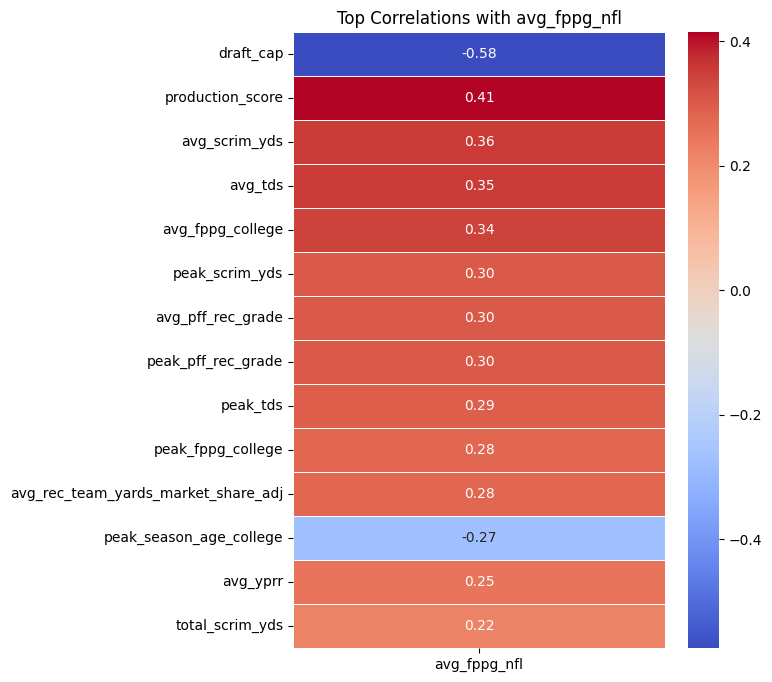

KeyError: 'cupps_score'

<Figure size 800x600 with 0 Axes>

In [157]:
# Compute correlation matrix
correlation_matrix = df_train.corr()

# Get correlations with avg_fppg_nfl and sort them (using abs since DC is inversely correlated)
correlations = correlation_matrix["avg_fppg_nfl"].dropna().abs().sort_values(ascending=False)

# Select the top N correlated features (excluding avg_fppg_nfl itself)
top_corr_features = correlations.index[1:15]  # Get top 10 correlated features

# Extract the correlation matrix for the selected features
top_corr_matrix = correlation_matrix.loc[top_corr_features, ["avg_fppg_nfl"]]

# Plot the heatmap
plt.figure(figsize=(6, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Top Correlations with avg_fppg_nfl")
plt.show()

# --- Scatter plot of cupps_score vs avg_fppg_nfl ---
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_train,
    x="cupps_score",
    y="avg_fppg_nfl",
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'red'}
    )
plt.title("Cupps Score vs NFL Avg FPPG")
plt.xlabel("Cupps Score")
plt.ylabel("Average NFL FPPG")
plt.grid(True)
plt.show()




In [158]:
# --- Features and target ---
y_train = df_train["avg_fppg_nfl"]
X_train = df_train.drop(columns=["avg_fppg_nfl"])
X_test = df_test.drop(columns=["avg_fppg_nfl"])

# --- Sample Weights ---
sample_weights = np.where(y_train > 15, 50,
                  np.where(y_train > 10, 10, 1))

# --- General Model ---
xgb_general = xgb.XGBRegressor(
    max_depth=6, n_estimators=500, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.7,
    objective="reg:pseudohubererror", random_state=42
)
xgb_general.fit(X_train, y_train, sample_weight=sample_weights)

# --- Quantile Model ---
xgb_quantile = xgb.XGBRegressor(
    max_depth=8, n_estimators=500, learning_rate=0.01,
    subsample=0.8, colsample_bytree=0.7,
    objective="reg:quantileerror", quantile_alpha=0.975,
    random_state=42
)
xgb_quantile.fit(X_train, y_train, sample_weight=sample_weights)

# --- Base Predictions ---
y_pred_general = xgb_general.predict(X_test)
y_pred_quantile = xgb_quantile.predict(X_test)

# --- Meta Features ---
meta_X = pd.DataFrame({
    "draft_cap": X_test["draft_cap"].fillna(300),
    # "cupps_score": X_test["cupps_score"],
    "production_score": X_test["production_score"],
    "size_score": X_test["size_score"],
    "avg_tds": X_test["avg_tds"],
    "avg_scrim_yds": X_test["avg_scrim_yds"],
    "avg_fppg_college": X_test["avg_fppg_college"],
    "peak_season_age_college": X_test["peak_season_age_college"],
    "avg_rec_team_yards_market_share_adj": X_test["avg_rec_team_yards_market_share_adj"],
    "general_pred": y_pred_general,
    "quantile_pred": y_pred_quantile,
}).fillna(0)

# --- Meta Training Set ---
meta_train_X = pd.DataFrame({
    "draft_cap": X_train["draft_cap"].fillna(300),
    # "cupps_score": X_train["cupps_score"],
    "production_score": X_train["production_score"],
    "size_score": X_train["size_score"],
    "avg_tds": X_train["avg_tds"],
    "avg_scrim_yds": X_train["avg_scrim_yds"],
    "avg_fppg_college": X_train["avg_fppg_college"],
    "peak_season_age_college": X_train["peak_season_age_college"],
    "avg_rec_team_yards_market_share_adj": X_train["avg_rec_team_yards_market_share_adj"],
    "general_pred": xgb_general.predict(X_train),
    "quantile_pred": xgb_quantile.predict(X_train),
}).fillna(0)

meta_model = xgb.XGBRegressor(
    max_depth=3, n_estimators=100, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8,
    objective="reg:squarederror", random_state=42
)
meta_model.fit(meta_train_X, y_train)

# --- Blending ---
meta_pred = meta_model.predict(meta_X)
error_general = np.abs(meta_pred - y_pred_general)
error_quantile = np.abs(meta_pred - y_pred_quantile)
elite_bonus = np.clip((meta_pred - 10) / 10, 0, 0.5)

blend_weight_quantile = np.clip((error_general / (error_general + error_quantile + 1e-8)) + elite_bonus, 0.05, 0.95)
blend_weight_general = 1 - blend_weight_quantile
y_pred_hybrid = (y_pred_quantile * blend_weight_quantile) + (y_pred_general * blend_weight_general)

# --- Attach Predictions ---
df_predictions = df_test_identifiers.copy()
df_predictions["predicted_fppg"] = y_pred_hybrid

# 🔽 Sort by predicted FPPG in descending order
df_predictions = df_predictions.sort_values(by="predicted_fppg", ascending=False).reset_index(drop=True)

# Save or print predictions
print(df_predictions)

    player_id                 name  predicted_fppg
0       17207  Marvin Harrison Jr.       15.953403
1       17387         Malik Nabers       15.484823
2       16296       Malachi Corley       14.949622
3       17085        Xavier Worthy       13.116472
4       16322          Rome Odunze       12.645798
5       17179        Troy Franklin       11.286886
6       17487        Ladd McConkey       10.687264
7       15855       Luke McCaffrey       10.586171
8       15645         Ainias Smith       10.322524
9       17389     Brian Thomas Jr.        9.335909
10      17325         Keon Coleman        9.261290
11      16390         Ja'lynn Polk        8.760510
12      16757      Jermaine Burton        8.339585
13      15156     Tyrone Tracy Jr.        6.695383
14      17486      Adonai Mitchell        6.291541
15      15553         Jacob Cowing        5.979580
16      16321       Jalen McMillan        5.241964
17      15697       Xavier Legette        5.225538
18      16899        Johnny Wil


✅ 62.86% of players were predicted within ±3 FPPG of their actual.
📊 Expected vs. Actual FPPG:
 Actual FPPG  Predicted FPPG  Residuals (Actual - Predicted)
       19.68       13.360106                        6.319894
       17.38       14.043274                        3.336726
       16.28       13.737389                        2.542611
       16.12       13.791272                        2.328728
       14.19       11.237332                        2.952668
       13.98       13.073899                        0.906101
       13.51       14.001824                       -0.491824
       12.61        8.993730                        3.616270
       11.93        9.198139                        2.731861
       11.06        9.870458                        1.189542
       11.01       11.199677                       -0.189677
       10.87        8.119027                        2.750973
       10.84        8.938651                        1.901349
       10.16        9.736281                      

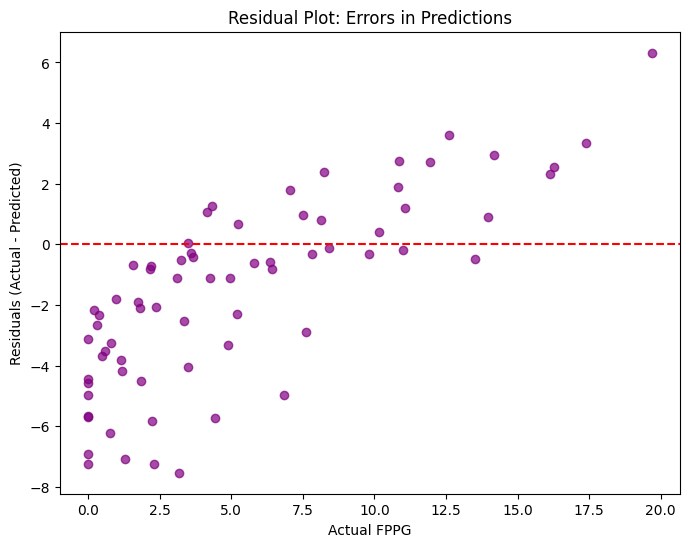

In [119]:
# 🔹 Compute Residuals
df_results = pd.DataFrame({
    "Actual FPPG": y_test_actual.values,
    "Predicted FPPG": y_pred_hybrid,
    "Residuals (Actual - Predicted)": y_test_actual.values - y_pred_hybrid
})

# 🔍 Calculate % of predictions within ±3 FPPG
within_3 = df_results["Residuals (Actual - Predicted)"].abs() <= 3
percent_within_3 = within_3.mean() * 100

print(f"\n✅ {percent_within_3:.2f}% of players were predicted within ±3 FPPG of their actual.")


# 🔹 Print Expected vs. Actual FPPG
print("📊 Expected vs. Actual FPPG:")
print(df_results.sort_values(by="Actual FPPG", ascending=False).to_string(index=False)) 

residuals = y_test_actual - y_pred_hybrid  # Actual - Predicted
# 🔹 Plot Residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, residuals, color="purple", alpha=0.7)
plt.axhline(y=0, color='red', linestyle='dashed')  # Zero error reference line
plt.xlabel("Actual FPPG")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot: Errors in Predictions")
plt.show()



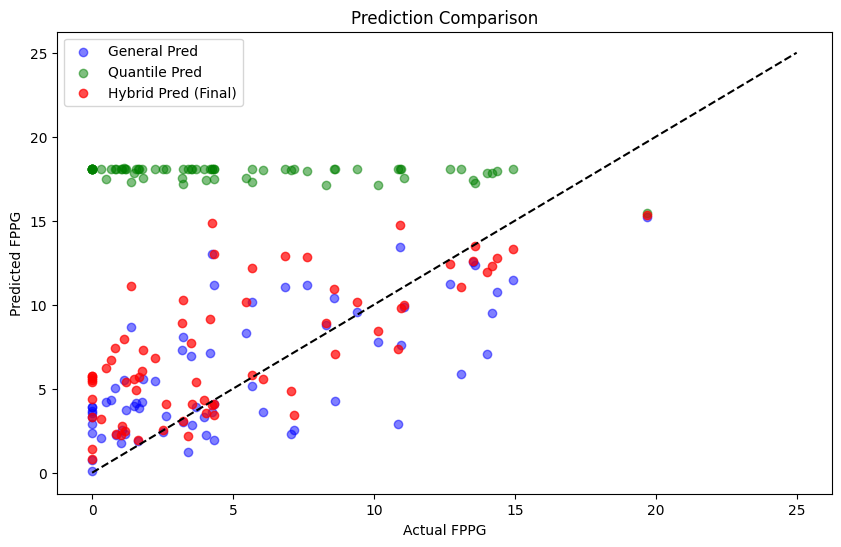

In [77]:
# Compare general vs quantile vs hybrid
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_pred_general, alpha=0.5, label="General Pred", color="blue")
plt.scatter(y_test_actual, y_pred_quantile, alpha=0.5, label="Quantile Pred", color="green")
plt.scatter(y_test_actual, y_pred_hybrid, alpha=0.7, label="Hybrid Pred (Final)", color="red")
plt.plot([0, 25], [0, 25], color="black", linestyle="--")  # perfect line
plt.xlabel("Actual FPPG")
plt.ylabel("Predicted FPPG")
plt.title("Prediction Comparison")
plt.legend()
plt.show()


In [78]:
# Step 1: Find the index of that row in the test set
target_actual = 0.8
target_pred = 13.082493  # or something close

# Tolerance for floating point match
tolerance = 0.1

# Find matching row
mask = (np.isclose(y_test_actual, target_actual, atol=1e-2)) & \
       (np.isclose(y_pred_hybrid, target_pred, atol=tolerance))

# Get the index in your DataFrame
matching_idx = y_test_actual[mask].index[0]

# Step 2: Look up the player info
print(df.loc[matching_idx])

IndexError: index 0 is out of bounds for axis 0 with size 0

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_1347/1807970066.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


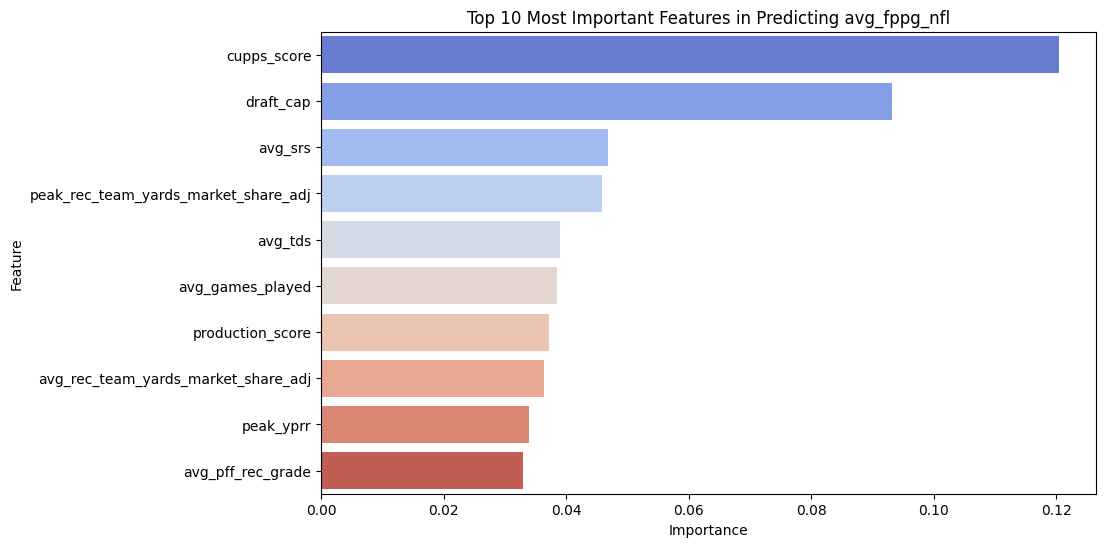

/var/folders/qr/nj1x3v_n3g1c86l2ynq5dqkc0000gp/T/ipykernel_1347/1807970066.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')


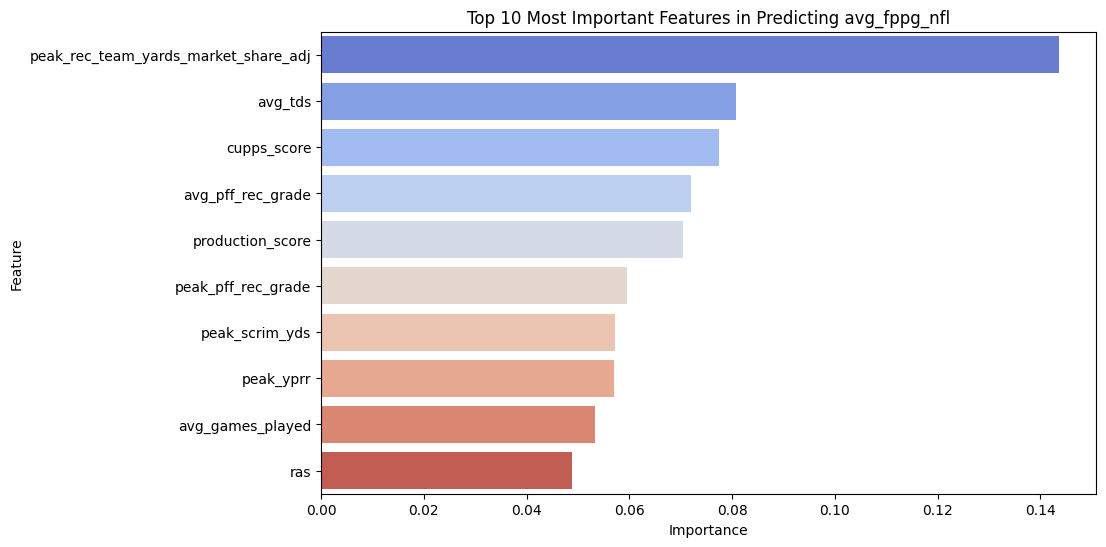

In [ ]:
def plot_xgboost_feature_importance(model):
    importance = model.feature_importances_
    feature_names = X_train.columns

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='coolwarm')
    plt.title("Top 10 Most Important Features in Predicting avg_fppg_nfl")
    plt.show()

plot_xgboost_feature_importance(xgb_general)
plot_xgboost_feature_importance(xgb_quantile)
